### Atterrissage et décollage / Trajectoire avion

In [1]:
import pandas as pd
import numpy as np
import ast
from openap import FlightPhase
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import pandas as pd
import numpy as np
import ast
import json
from openap import FlightPhase
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D

data_new_na = pd.read_csv('data_join.csv')

list_time = data_new_na.timestamp_s
list_type = data_new_na.type_avion
list_tas = data_new_na.TAS
list_alt = data_new_na.altitude
list_distance = data_new_na.distance_aero
list_rate = data_new_na.vertical_rate

In [3]:
def test_segment(labels, ts, alt, spd, roc):

    phasecolors = {
        'GND': 'black',     #ground
        'CL': 'green',      #climb
        'DE': 'blue',       #descend
        'LVL': 'cyan',      #level
        'CR': 'purple',     #cruise (vitesse cste ou alt cste)
        'NA': 'red'         #not available
    }

    colors = [phasecolors[lbl] for lbl in labels]

    plt.subplot(311)
    plt.scatter(ts, alt, marker='.', c=colors, lw=0)
    plt.ylabel('altitude (ft)')

    plt.subplot(312)
    plt.scatter(ts, spd, marker='.', c=colors, lw=0)
    plt.ylabel('speed (kt)')

    plt.subplot(313)
    plt.scatter(ts, roc, marker='.', c=colors, lw=0)
    plt.ylabel('roc (fpm)')

    plt.show()

list_decollage = []
list_atterrissage = []
for nb in range(len(list_alt)) :
    
    ts = np.array(ast.literal_eval(list_time[nb]))
    spd = np.array(ast.literal_eval(list_tas[nb]))
    alt = np.array(ast.literal_eval(list_alt[nb]))
    distance = np.array(ast.literal_eval(list_distance[nb]))
    roc = np.array(ast.literal_eval(list_rate[nb]))
    tas_, alt_ = np.meshgrid(spd, alt)

    distance_index = np.argmin(distance)
    distance_min = distance[distance_index]
    alt_min = alt[distance_index] 
    #roc_min = roc[distance_index]
    sueil = 30    #depend des aeroports alentours
    seuil_alt = 500  #feets
    dict = {}
    if  (distance_min < sueil and alt_min < seuil_alt) : 
        #print(distance_min)
        #print(alt_min)
        
        # Calcul des différences entre chaque mesure de vitesse
        diff = np.diff(roc)

        # Recherche des indices des changements de signe (décollage ou atterrissage)
        sign_change = np.where(np.diff(np.sign(diff)))[0]

        # Séparation des intervalles de décollage et d'atterrissage
        intervals_roc = np.split(roc, sign_change)
        intervals_time = np.split(ts, sign_change)

        # Decider si atterrissage ou décollage
        dict["DECOLLAGE"] = []
        dict["ATTERRISSAGE"] = []
        for i, interval in enumerate(intervals_roc):
            try :
                if (interval[0] > 0) & (len(interval) >=5 ):
                    dict["DECOLLAGE"].append(intervals_time[i].tolist())
                elif (interval[0] < 0) & (len(interval) >=5 ): 
                    dict["ATTERRISSAGE"].append(intervals_time[i].tolist())
            except : 
                print("liste vide")


        list_decollage.append(json.dumps(dict["DECOLLAGE"]))
        list_atterrissage.append(json.dumps(dict["ATTERRISSAGE"]))

    else :
        list_decollage.append("[0]")       #Pas sur Toulouse
        list_atterrissage.append("[0]")


data_new_na.loc[:, 'DECOLLAGE'] = list_decollage
data_new_na.loc[:, 'ATTERRISSAGE'] = list_atterrissage


        #fp = FlightPhase()
        #fp.set_trajectory(ts, alt, spd, roc)
        #labels = fp.phaselabel()
        #test_segment(labels, ts, alt, spd, roc)

data_new_na
        

,icao_address,tale_nb,type_avion,jet_prive,serial_nb,Flight_ID,timestamp_s,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,DECOLLAGE,ATTERRISSAGE
0,020095,CN-ROU,B738,Royal Air Maroc,33069,"['RAM792Y', 'RAM792Y', 'RAM792Y', 'RAM792Y', '...","[1664367899, 1664367898, 1664367895, 166436789...","[37025, 37025, 37025, 37025, 37025, 37025, 370...","[-0.7567457719282515, -0.7567457719282515, -0....","[41.98164367675781, 41.98164367675781, 41.9953...","[252.1735202987829, 252.1735202987829, 250.397...","[439, 440, 440, 439, 439, 439, 439, 439, 440, ...","[-64, -64, -64, -64, -64, 0, 0, 0, 0, 0, 0, 0,...",[0],[0]
1,02a197,TS-IMX,A20N,Unkown,Unkown,"['TAR282', 'TAR282', 'TAR282', 'TAR282', 'TAR2...","[1664375476, 1664375463, 1664375462, 166437546...","[650, 650, 650, 650, 650, 650, 650, 650, 650, ...","[1.3653128487723214, 1.3653128487723214, 1.365...","[43.625498626191735, 43.625498626191735, 43.62...","[0.4610400012559232, 0.4610400012559232, 0.461...","[2, 2, 2, 3, 4, 4, 5, 5, 6, 7, 8, 8, 7, 7, 6, ...","[-64, -64, -64, -64, -64, -64, -64, -64, -64, ...",[0],[0]
2,3452c8,EC-MLO,CRJX,Croatia Airlines,19050,"['ANE8699', 'ANE8699', 'ANE8699', 'ANE8699', '...","[1664366695, 1664366684, 1664366683, 166436664...","[33000, 33000, 33000, 33000, 33000, 33000, 330...","[-2.3943807912427246, -2.3319105668501265, -2....","[41.97410454184322, 42.05223083496094, 42.0522...","[357.82016940463683, 348.8541995677333, 348.85...","[402, 403, 403, 405, 405, 405, 405, 405, 405, ...","[-64, 64, 64, 128, 128, -64, -64, 0, 0, 0, 0, ...",[0],[0]
3,345698,EC-MVC,CRJX,Air Nostrum,19062,"['ANE14DZ', 'ANE14DZ', 'ANE14DZ', 'ANE14DZ', '...","[1664376245, 1664376244, 1664376242, 166437624...","[650, 650, 650, 650, 650, 650, 650, 650, 650, ...","[1.361346577489099, 1.361346577489099, 1.36134...","[43.62931823730469, 43.62931823730469, 43.6293...","[0.5033107986195029, 0.5033107986195029, 0.503...","[0, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 7, 7, ...","[-64, -64, -64, -64, -64, -64, -64, -64, -64, ...",[0],[0]
4,3461cf,EC-NDH,A319,Unkown,Unkown,"['VOE72VE', 'VOE72VE', 'VOE72VE', 'VOE72VE', '...","[1664348981, 1664348980, 1664348979, 166434897...","[575, 575, 575, 575, 575, 575, 575, 575, 575, ...","[1.3623046875, 1.3623046875, 1.3623046875, 1.3...","[43.62835693359375, 43.62835693359375, 43.6283...","[0.43890781915314797, 0.43890781915314797, 0.4...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 12, 13, 14...","[-64, -64, -64, -64, -64, -64, -64, -64, -64, ...",[0],[0]
5,3465c9,EC-ISI,A320,Unkown,Unkown,"['VOE27EX', 'VOE27EX', 'VOE27EX', 'VOE27EX', '...","[1664376568, 1664376567, 1664376566, 166437656...","[30000, 30000, 30000, 29975, 29975, 29975, 299...","[5.025307259908537, 5.025307259908537, 5.02530...","[44.61748026185116, 44.61748026185116, 44.6174...","[311.9168067316493, 311.9168067316493, 311.916...","[397, 397, 398, 398, 398, 399, 399, 399, 399, ...","[64, 64, 128, 128, 192, 448, 448, 448, 448, 44...",[0],[0]
6,38a6fb,F-WXWB,A359,Airbus Industries,1,"['AIB69WB', 'AIB69WB', 'AIB69WB', 'AIB69WB', '...","[1664357896, 1664357889, 1664357888, 166435788...","[575, 575, 575, 600, 600, 625, 625, 625, 650, ...","[1.3682449695675873, 1.3682449695675873, 1.368...","[43.62272644042969, 43.62272644042969, 43.6222...","[0.7327876437368419, 0.7327876437368419, 0.790...","[109, 131, 131, 131, 132, 134, 134, 135, 135, ...","[-128, -384, -384, -384, -384, -320, -320, -44...",[0],[0]
7,393320,F-GMZA,A321,Air France,498,"['AFR43LV', 'AFR43LV', 'AFR43LV', 'AFR43LV', '...","[1664388763, 1664388760, 1664388756, 166438875...","[27975, 27975, 27950, 27950, 27950, 27950, 279...","[1.1803763253348214, 1.1803763253348214, 1.180...","[45.33879089355469, 45.33879089355469, 45.3306...","[190.66593590696192, 190.66593590696192, 189.7...","[468, 469, 469, 469, 470, 470, 470, 470, 471, ...","[64, 192, 192, 192, 320, 320, 320, 448, 512, 5...",[0],[0]
8,393322,F-GMZC,A321,Air France,521,"['AFR74FD', 'AFR74FD', 'AFR74FD', 'AFR74FD', '...","[1664372381, 1664372380, 1664372374, 166437226...","[

### Objectif 3 : trajectoire et type avion

In [14]:
nb = 7

ac = list_type[nb]       #type avion

aircraft = prop.aircraft(ac)
fuelflow = FuelFlow(ac=ac)
emission = Emission(ac=ac)

ts = np.array(ast.literal_eval(list_time[nb]))
spd = np.array(ast.literal_eval(list_tas[nb]))
alt = np.array(ast.literal_eval(list_alt[nb]))
distance = np.array(ast.literal_eval(list_distance[nb]))
roc = np.array(ast.literal_eval(list_rate[nb]))
tas_, alt_ = np.meshgrid(spd, alt)


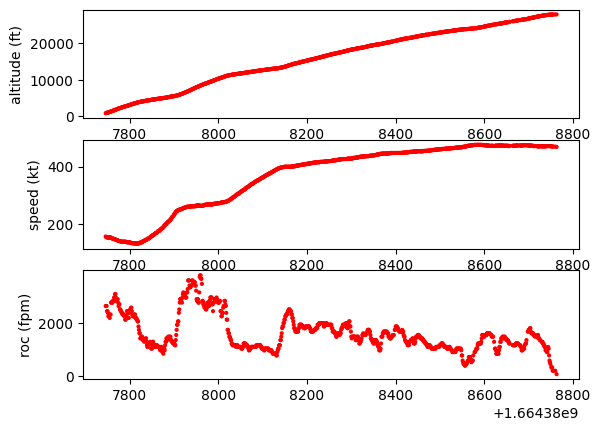

In [15]:
fp = FlightPhase()
fp.set_trajectory(ts, alt, spd, roc)
labels = fp.phaselabel()
test_segment(labels, ts, alt, spd, roc)

In [20]:
data_new_na.loc[41].to_csv('data_toulouse_att_dec.csv')